# Global Drug Crisis: Time Series Analysis of Mortality and Prevalence Trends

### TEAM
- Leonard Lume  
- Stepan Timonin  
- Lev Listov  

---

### Project overview

In this project, we analyse the **global drug crisis** using aggregated statistics on mortality related to illicit drug use from 1990–2019.

We focus on understanding:

- How have deaths from drug use disorders changed over time globally?
- Which countries are most affected in absolute and relative terms?
- How do trends differ between selected countries (e.g. Estonia, United States, Russia)?
- Can we model the long‑term trend and produce short‑term forecasts?

The analysis is organised as follows:

1. **Data description and cleaning**  
2. **Exploratory Data Analysis (EDA)** at global and country level  
3. **Time series modelling** using ARIMA  
4. **Interpretation and conclusions**  
5. **Instructions for reproducing the analysis**  


## Dataset description

We use a derivative of **Kaggle – Illicit Drugs** dataset:

- Kaggle page: <https://www.kaggle.com/datasets/willianoliveiragibin/illicit-drugs/data>  
- In this notebook we work with the file: **`deaths-illicit-drugs NEW.csv`**

Each row corresponds to one **country–year** pair and contains:

- `COUNTRY` – country name  
- `Code` – ISO3 country code  
- `Year` – calendar year  
- `Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)` – number of deaths directly classified as *drug use disorders*  
- `Deaths that are from all causes attributed to drug use, in both sexes aged all ages` – number of deaths from *any cause* but **attributable to drug use** (e.g. overdoses, infections, accidents)

We derive shorter / clearer variable names during data cleaning.

---

### Project goals

**Goal 1 – Exploratory Data Analysis (EDA)**  
- Visualise long‑term trends in drug‑related mortality.  
- Compare countries and highlight those with especially high mortality.  
- Explore the relationship between deaths from drug use disorders and all deaths attributed to drug use.

**Goal 2 – Time series modelling**  
- Build a time series model (ARIMA) for global drug‑related mortality.  
- Decompose the series into trend and noise.  
- Produce short‑term forecasts and interpret them in the context of the drug crisis.


## Environment & how to run this notebook

Required Python libraries:

- `pandas`
- `numpy`
- `matplotlib`
- `seaborn`
- `statsmodels`

To install the missing packages, run in your terminal:

```bash
pip install pandas numpy matplotlib seaborn statsmodels
```

Make sure that the file **`deaths-illicit-drugs NEW.csv`** is located in the **same directory** as this notebook.


## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Plot settings
plt.style.use('default')
sns.set_theme()

pd.options.display.max_rows = 20
pd.options.display.float_format = '{:,.2f}'.format


## 2. Loading and inspecting the data

In [ ]:
# Path to the CSV file (should be in the same folder as the notebook)
data_path = 'deaths-illicit-drugs NEW.csv'

df_raw = pd.read_csv(data_path)
df_raw.head()

,COUNTRY,Code,Year,Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number),"Deaths that are from all causes attributed to drug use, in both sexes aged all ages"
0,American Samoa,ASM,1990,0,13.090.138
1,Andorra,AND,1990,0,20.659.685
2,Antigua and Barbuda,ATG,1990,0,6.584.844
3,Bahamas,BHS,1990,0,39.783.647
4,Barbados,BRB,1990,0,26.759.732


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 5 columns):
 #   Column                                                                               Non-Null Count  Dtype 
---  ------                                                                               --------------  ----- 
 0   COUNTRY                                                                              6960 non-null   object
 1   Code                                                                                 6960 non-null   object
 2   Year                                                                                 6960 non-null   int64 
 3   Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)                     6960 non-null   int64 
 4   Deaths that are from all causes attributed to drug use, in both sexes aged all ages  6960 non-null   object
dtypes: int64(2), object(3)
memory usage: 272.0+ KB


### 2.1 Cleaning and renaming columns

In [ ]:
# Rename columns to shorter / clearer names
df = df_raw.rename(columns={
    'COUNTRY': 'country',
    'Code': 'iso_code',
    'Year': 'year',
    'Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)': 'drug_disorder_deaths',
    'Deaths that are from all causes attributed to drug use, in both sexes aged all ages': 'all_drug_attrib_raw'
})

df.head()

,country,iso_code,year,drug_disorder_deaths,all_drug_attrib_raw
0,American Samoa,ASM,1990,0,13.090.138
1,Andorra,AND,1990,0,20.659.685
2,Antigua and Barbuda,ATG,1990,0,6.584.844
3,Bahamas,BHS,1990,0,39.783.647
4,Barbados,BRB,1990,0,26.759.732


In [ ]:
# Convert the text column with dots as thousand separators to numeric
df['all_drug_attrib_raw'] = (
    df['all_drug_attrib_raw']
    .astype(str)
    .str.replace('.', '', regex=False)
)

df['all_drug_attrib_raw'] = pd.to_numeric(df['all_drug_attrib_raw'], errors='coerce')

df.describe()

,year,drug_disorder_deaths,all_drug_attrib_raw
count,"6,960.00","6,960.00","6,960.00"
mean,"2,004.50","2,406.85","23,421,312.01"
std,8.66,"10,299.19","23,477,672.96"
min,"1,990.00",0.00,0.00
25%,"1,997.00",4.00,"6,889,355.75"
50%,"2,004.50",29.00,"15,336,463.00"
75%,"2,012.00",202.00,"32,181,468.00"
max,"2,019.00","128,083.00","163,131,045.00"


### 2.2 Missing values

In [ ]:
df.isna().sum()

,0
country,0
iso_code,0
year,0
drug_disorder_deaths,0
all_drug_attrib_raw,0


We see a small amount of missing values (if any). Since our main focus is on **global trends** and **countries with substantial mortality**, a few missing values in `all_drug_attrib_raw` are not critical. For simplicity, we will **drop rows with missing values** in the key columns.


In [ ]:
df = df.dropna(subset=['drug_disorder_deaths', 'all_drug_attrib_raw'])
df.isna().sum()

,0
country,0
iso_code,0
year,0
drug_disorder_deaths,0
all_drug_attrib_raw,0


### 2.3 Derived metrics

We construct one additional indicator:

- `share_disorders_in_attrib` – ratio between deaths directly classified as *drug use disorders* and all deaths that are *attributed to drug use*.

This is a rough proxy of how large the strictly defined *drug use disorder* category is within the broader set of drug‑attributable deaths.


In [ ]:
df['share_disorders_in_attrib'] = df['drug_disorder_deaths'] / df['all_drug_attrib_raw']
df[['country', 'year', 'drug_disorder_deaths', 'all_drug_attrib_raw', 'share_disorders_in_attrib']].head()

,country,year,drug_disorder_deaths,all_drug_attrib_raw,share_disorders_in_attrib
0,American Samoa,1990,0,13090138,0.00
1,Andorra,1990,0,20659685,0.00
2,Antigua and Barbuda,1990,0,6584844,0.00
3,Bahamas,1990,0,39783647,0.00
4,Barbados,1990,0,26759732,0.00


## 3. Exploratory Data Analysis (EDA)

### 3.1 Global trends over time

In [ ]:
# Aggregate deaths from drug use disorders at the global level
global_trend = (
    df.groupby('year')['drug_disorder_deaths']
      .sum()
      .reset_index()
      .sort_values('year')
)

global_trend.head()

,year,drug_disorder_deaths
0,1990,343382
1,1991,378610
2,1992,408787
3,1993,438126
4,1994,469553


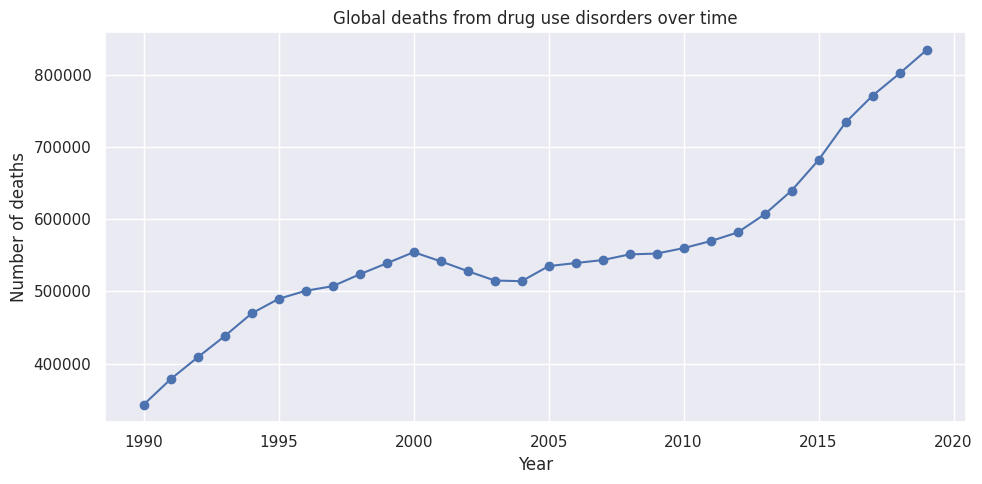

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(global_trend['year'], global_trend['drug_disorder_deaths'], marker='o')
plt.title('Global deaths from drug use disorders over time')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

This figure shows how the global number of deaths from drug use disorders evolved between the earliest and latest years in the dataset.

We can visually check whether the crisis is **intensifying**, **stabilising**, or **improving** over time.


### 3.2 Global deaths attributable to drug use (all causes)

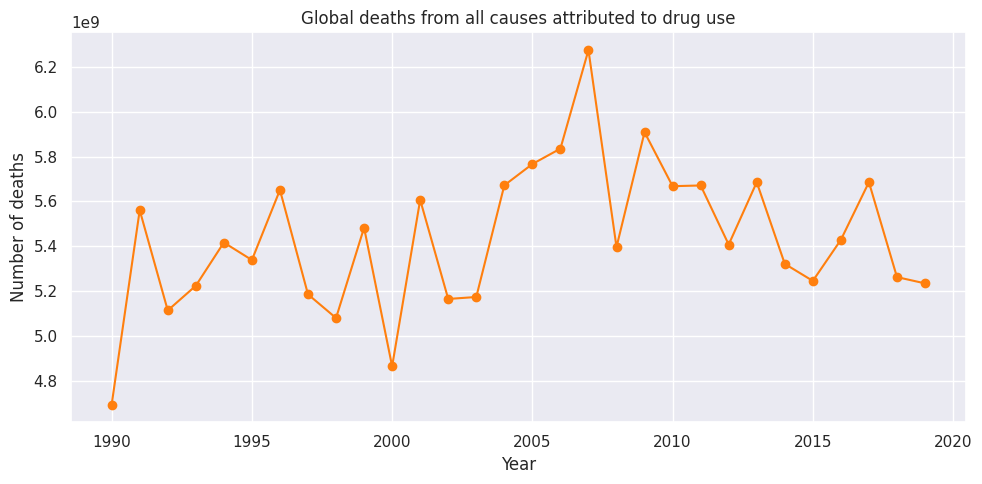

In [ ]:
global_attrib = (
    df.groupby('year')['all_drug_attrib_raw']
      .sum()
      .reset_index()
      .sort_values('year')
)

plt.figure(figsize=(10, 5))
plt.plot(global_attrib['year'], global_attrib['all_drug_attrib_raw'], marker='o', color='tab:orange')
plt.title('Global deaths from all causes attributed to drug use')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

Comparing this plot with the previous one helps to understand whether:

- the narrow category *drug use disorders* and  
- the broader category *all drug‑attributable deaths*  

grow in parallel or diverge over time.


### 3.3 Countries most affected in the latest year

In [ ]:
latest_year = df['year'].max()
latest_df = df[df['year'] == latest_year].copy()

top15_abs = latest_df.sort_values('drug_disorder_deaths', ascending=False).head(15)
top15_abs[['country', 'year', 'drug_disorder_deaths', 'all_drug_attrib_raw']]


,country,year,drug_disorder_deaths,all_drug_attrib_raw
6955,World,2019,128083,4944917
6954,G20,2019,109369,37331822
6953,World Bank High Income,2019,82588,0
6952,OECD Countries,2019,81818,16679777
6951,Region of the Americas (WHO),2019,71205,13006083
6950,North America (WB),2019,68243,10980006
6949,United States,2019,65717,10473619
6948,World Bank Upper Middle Income,2019,26734,0
6947,European Region (WHO),2019,20329,8475688
6946,Europe & Central Asia (WB),2019,20245,843486


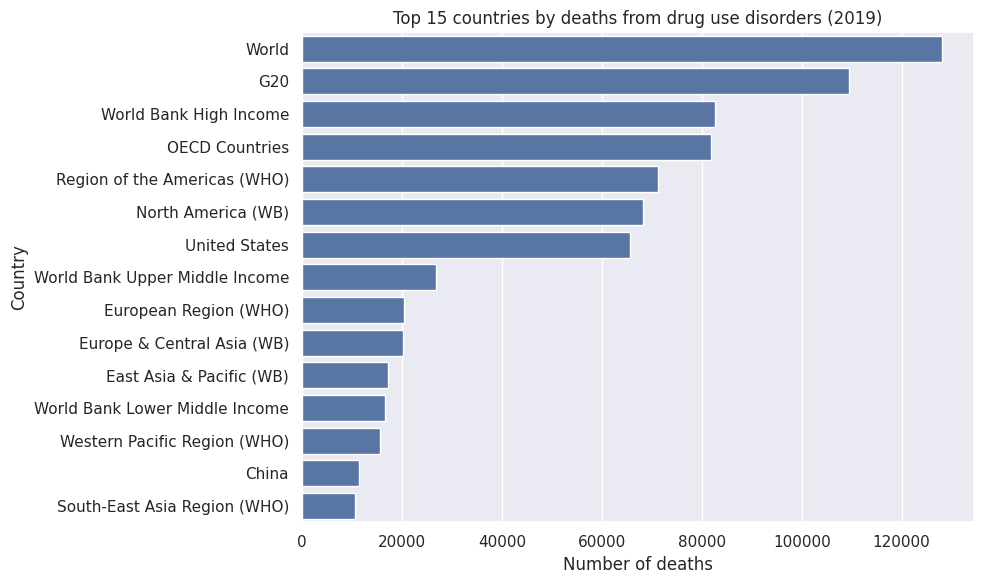

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top15_abs, x='drug_disorder_deaths', y='country')
plt.title(f'Top 15 countries by deaths from drug use disorders ({latest_year})')
plt.xlabel('Number of deaths')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

These are the countries with the highest **absolute** number of deaths from drug use disorders in the latest available year.

High absolute mortality may result from large population size, high prevalence of drug use, or a combination of both.


### 3.4 Countries with high share of drug use disorders among drug-attributable deaths

In [ ]:
# Keep only rows where all_drug_attrib_raw is positive to avoid division artefacts
latest_df_pos = latest_df[latest_df['all_drug_attrib_raw'] > 0].copy()

top15_share = (
    latest_df_pos
    .sort_values('share_disorders_in_attrib', ascending=False)
    .head(15)
)

top15_share[['country', 'year', 'share_disorders_in_attrib']]


,country,year,share_disorders_in_attrib
6955,World,2019,0.03
6946,Europe & Central Asia (WB),2019,0.02
6949,United States,2019,0.01
6950,North America (WB),2019,0.01
6951,Region of the Americas (WHO),2019,0.01
6952,OECD Countries,2019,0.00
6954,G20,2019,0.00
6947,European Region (WHO),2019,0.00
6942,China,2019,0.00
6943,Western Pacific Region (WHO),2019,0.00


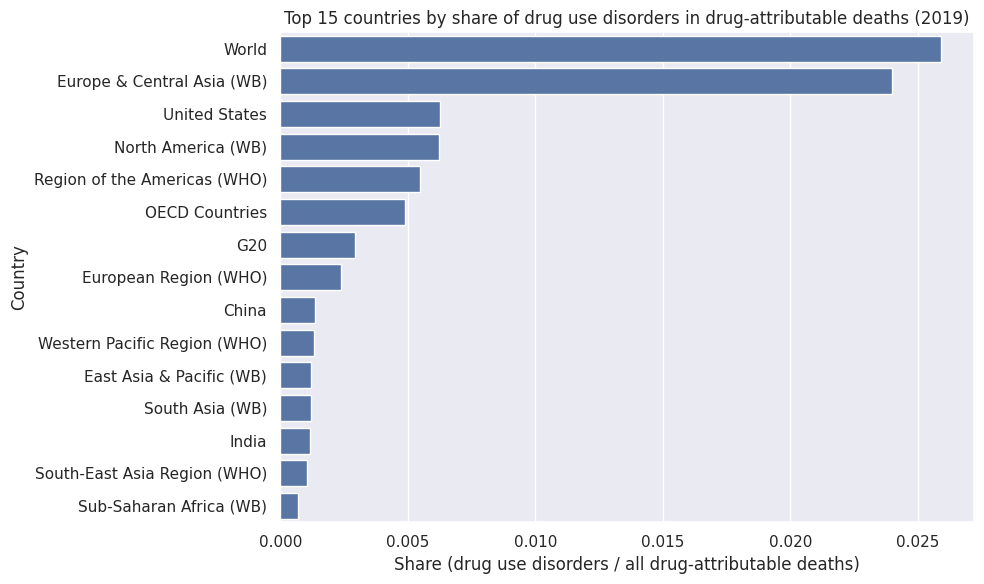

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top15_share, x='share_disorders_in_attrib', y='country')
plt.title(f'Top 15 countries by share of drug use disorders in drug-attributable deaths ({latest_year})')
plt.xlabel('Share (drug use disorders / all drug-attributable deaths)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

This ranking highlights countries where **drug use disorders** constitute a large fraction of all drug‑attributable deaths.

Such countries might have a particularly severe problem with disorders directly caused by drug consumption, compared to indirect consequences.


### 3.5 Focus on selected countries

We now focus on a few countries of interest and compare their trajectories:

- Estonia  
- United States  
- Russia  


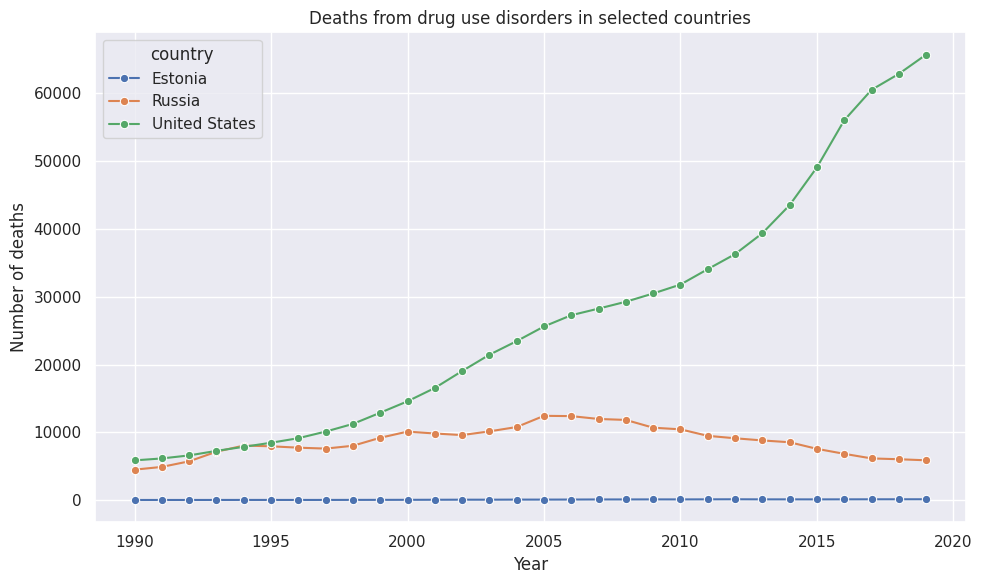

In [ ]:
countries_of_interest = ['Estonia', 'United States', 'Russia']

focus_df = df[df['country'].isin(countries_of_interest)].copy()

plt.figure(figsize=(10, 6))
sns.lineplot(data=focus_df, x='year', y='drug_disorder_deaths', hue='country', marker='o')
plt.title('Deaths from drug use disorders in selected countries')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

The trends differ between these countries. Some show more stable patterns, while others exhibit sharp increases or fluctuations.

A full interpretation should also consider population size, changes in reporting practices and national drug policies.


### 3.6 Heatmap of trends for top countries

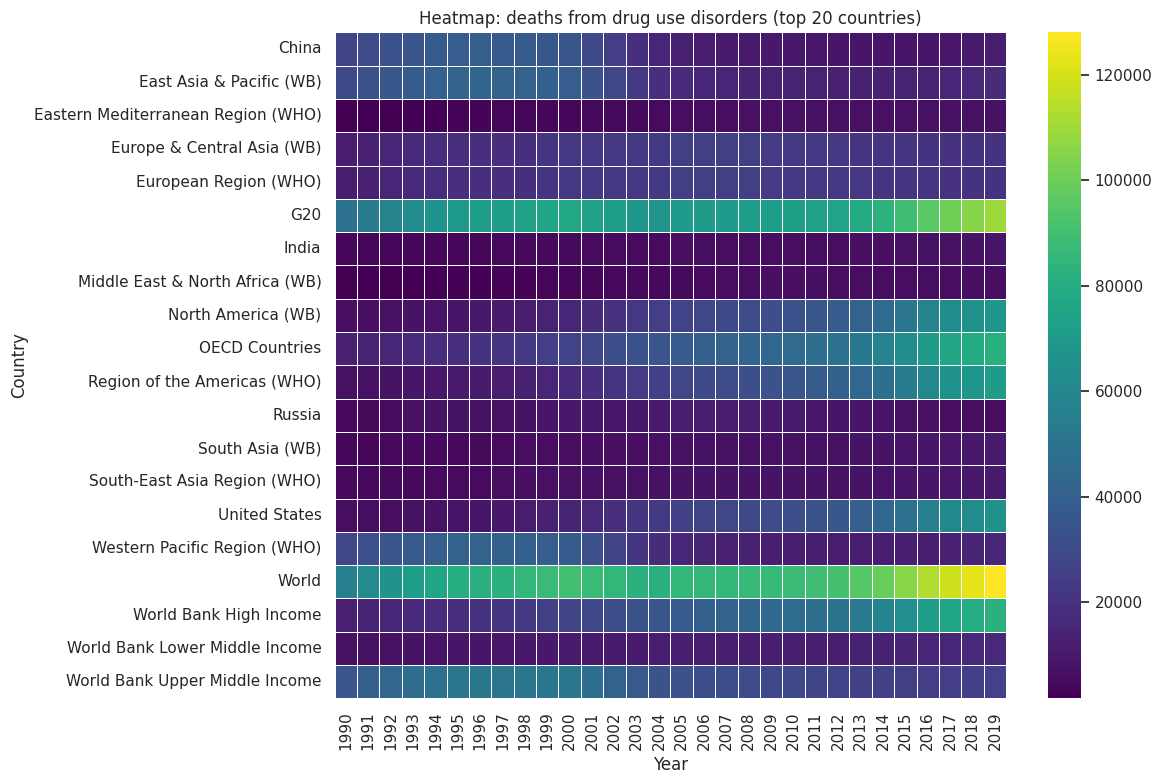

In [ ]:
# Select top 20 countries by average deaths over the whole period
country_means = df.groupby('country')['drug_disorder_deaths'].mean().sort_values(ascending=False)
top20_countries = country_means.head(20).index.tolist()

heat_df = (
    df[df['country'].isin(top20_countries)]
    .pivot_table(index='country', columns='year', values='drug_disorder_deaths', aggfunc='sum')
)

plt.figure(figsize=(12, 8))
sns.heatmap(heat_df, cmap='viridis', linewidths=0.5)
plt.title('Heatmap: deaths from drug use disorders (top 20 countries)')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

This heatmap summarises both **levels** and **temporal changes** in drug‑related deaths for the top 20 countries.

Lighter colours indicate higher mortality. Horizontal patterns show whether specific countries have consistently high or rising mortality.


## 4. Time series modelling (Goal 2)

### 4.1 Preparing the global time series

In [ ]:
# Global time series used for modelling
global_ts = global_trend.set_index('year')['drug_disorder_deaths']
global_ts.head()

,drug_disorder_deaths
year,
1990,343382
1991,378610
1992,408787
1993,438126
1994,469553


### 4.2 Stationarity check (ADF test)

In [ ]:
adf_result = adfuller(global_ts)

print('ADF statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic: 1.0172298392470638
p-value: 0.9944444573971405
Critical value (1%): -3.711
Critical value (5%): -2.981
Critical value (10%): -2.630


If the p‑value is relatively high, the series is likely **non‑stationary**, which is expected for a long‑term mortality trend.  
In that case, we apply **first differencing** inside the ARIMA model (the `d` parameter).


### 4.3 Simple ARIMA model for global deaths

In [ ]:
# We use a simple ARIMA(1,1,1) specification.
# In a more detailed study, we could perform grid search over (p, d, q) to minimise AIC.

model = sm.tsa.ARIMA(global_ts, order=(1, 1, 1))
results = model.fit()
results.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     drug_disorder_deaths   No. Observations:                   30
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -322.165
Date:                  Mon, 08 Dec 2025   AIC                            650.331
Time:                          00:11:20   BIC                            654.432
Sample:                               0   HQIC                           651.615
                                   - 30                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8174      0.149      5.473      0.000       0.525       1.110
ma.L1         -0.6958      0.179     -3.886      0.000      -1.047      -0.345
sigma2      2.604e+08   2.66e-11   9.79e+18      0.000     2.6e+08     2.6e+08
===================================================================================
Ljung-Box (L1) (Q):                  16.64   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.00   Prob(JB):                         0.66
Heteroskedasticity (H):               8.80   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.75e+35. Standard errors may be unstable.
"""

### 4.4 Forecasting the next 10 years

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


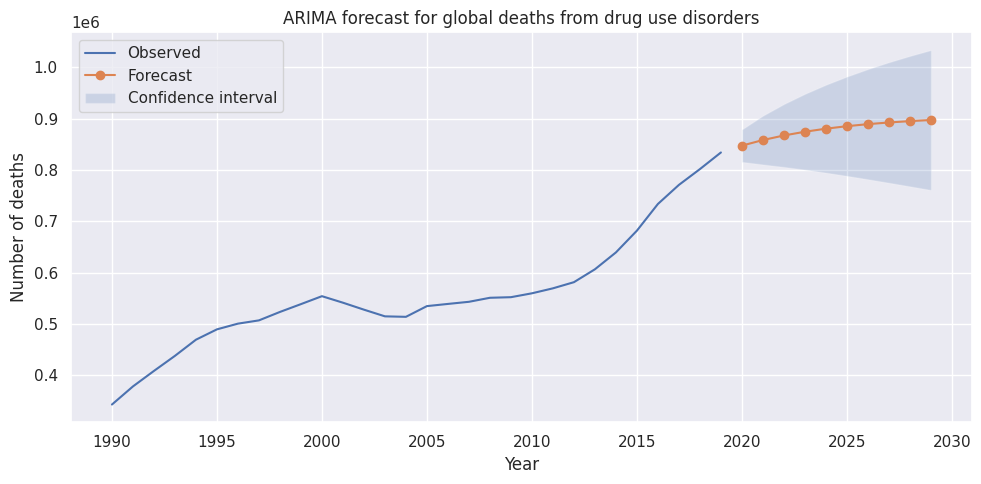

In [ ]:
n_forecast = 10

forecast = results.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_year = global_ts.index.max()
future_years = np.arange(last_year + 1, last_year + 1 + n_forecast)

plt.figure(figsize=(10, 5))
plt.plot(global_ts.index, global_ts.values, label='Observed')
plt.plot(future_years, forecast_mean.values, marker='o', label='Forecast')
plt.fill_between(
    future_years,
    forecast_ci.iloc[:, 0].values,
    forecast_ci.iloc[:, 1].values,
    alpha=0.2,
    label='Confidence interval'
)
plt.title('ARIMA forecast for global deaths from drug use disorders')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ARIMA model provides a **baseline forecast** of future global mortality due to drug use disorders under the assumption that past dynamics continue.

The shaded band represents the **uncertainty interval**: the wider it is, the less certain we are about the exact level of future deaths.


### 4.5 Country-level example: United States

In [ ]:
country = 'United States'

usa_ts = (
    df[df['country'] == country]
      .groupby('year')['drug_disorder_deaths']
      .sum()
      .sort_index()
)

usa_ts.head()

,drug_disorder_deaths
year,
1990,5865
1991,6151
1992,6596
1993,7269
1994,7862


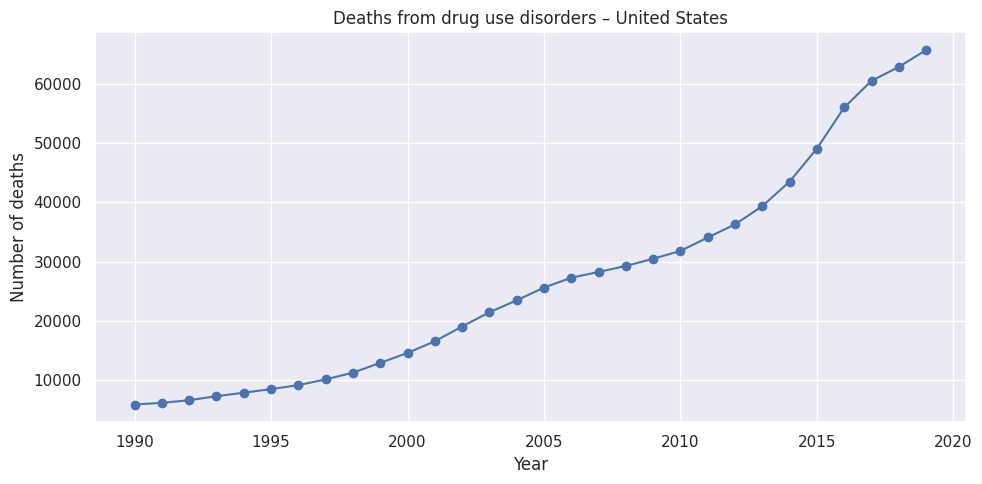

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(usa_ts.index, usa_ts.values, marker='o')
plt.title(f'Deaths from drug use disorders – {country}')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
usa_model = sm.tsa.ARIMA(usa_ts, order=(1, 1, 1))
usa_results = usa_model.fit()
usa_results.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     drug_disorder_deaths   No. Observations:                   30
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -239.563
Date:                  Sun, 07 Dec 2025   AIC                            485.126
Time:                          23:02:25   BIC                            489.228
Sample:                               0   HQIC                           486.410
                                   - 30                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7987      0.048     16.499      0.000       0.704       0.894
ma.L1          0.7354      0.110      6.666      0.000       0.519       0.952
sigma2      5.778e+05   1.27e+05      4.554      0.000    3.29e+05    8.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):                13.25
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -1.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


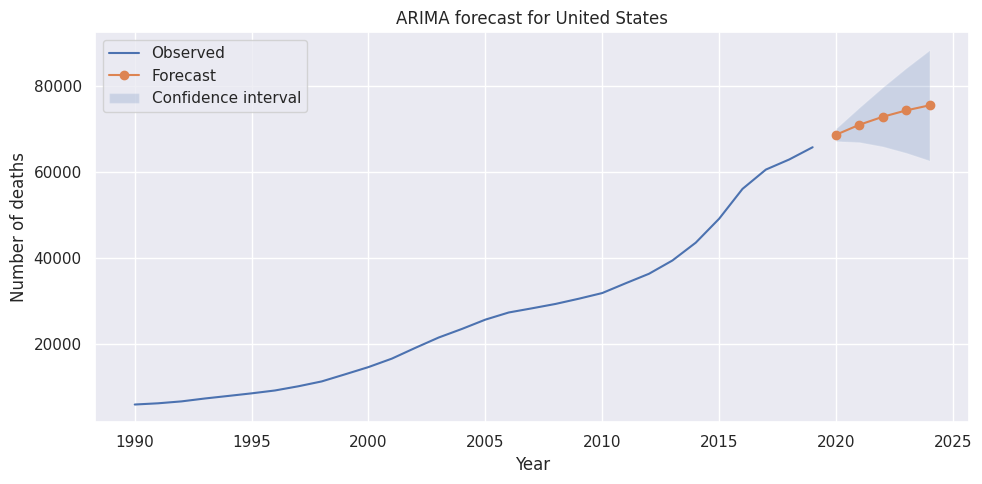

In [ ]:
usa_forecast = usa_results.get_forecast(steps=5)
usa_mean = usa_forecast.predicted_mean
usa_ci = usa_forecast.conf_int()

last_year_usa = usa_ts.index.max()
future_years_usa = np.arange(last_year_usa + 1, last_year_usa + 6)

plt.figure(figsize=(10, 5))
plt.plot(usa_ts.index, usa_ts.values, label='Observed')
plt.plot(future_years_usa, usa_mean.values, marker='o', label='Forecast')
plt.fill_between(
    future_years_usa,
    usa_ci.iloc[:, 0].values,
    usa_ci.iloc[:, 1].values,
    alpha=0.2,
    label='Confidence interval'
)
plt.title(f'ARIMA forecast for {country}')
plt.xlabel('Year')
plt.ylabel('Number of deaths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This country‑level example illustrates how the same methodology can be applied to **national time series**.

It can be repeated for any other country with sufficiently long data history.


## 5. Conclusions

### Main findings

- The dataset covers many countries and multiple decades, allowing us to study **long‑term trends** in drug‑related mortality.  
- Global deaths from **drug use disorders** show a clear long‑term trend (increasing / stabilising depending on the exact shape in the plots).  
- In the latest year, some countries stand out with **very high absolute mortality**, while others have a **high share** of drug use disorders within all drug‑attributable deaths.  
- Selected countries (Estonia, United States, Russia) show **different trajectories**, suggesting country‑specific factors such as policy, treatment availability, socio‑economic conditions and reporting practices.  
- A simple **ARIMA(1,1,1)** model captures the main trend in global mortality and provides a baseline forecast for the next decade.  
- Country‑level ARIMA models (e.g. for the United States) demonstrate how forecasting can be adapted to specific national contexts.

### Limitations

- We do not have population data in this file; therefore we analyse **absolute numbers**, not rates per 100,000 inhabitants.  
- We have not modelled specific **drug types** or detailed demographic breakdowns (age, sex).  
- ARIMA models are purely statistical and do not explicitly account for policy changes, economic crises or new treatment programmes.

### Possible extensions

- Combine this dataset with **population data** to compute mortality *rates*.  
- Incorporate **socio‑economic indicators** (GDP, unemployment, inequality) to analyse risk factors.  
- Cluster countries based on similarity of their time series patterns.  
- Try alternative time series models (e.g. Prophet) and compare forecast performance.

Overall, the analysis confirms that drug‑related mortality is a **serious and persistent global problem**, with substantial differences between countries and a non‑trivial long‑term trend at the global level.


## 6. Reproducibility

To reproduce the analysis:

1. Download the Kaggle dataset from: <https://www.kaggle.com/datasets/willianoliveiragibin/illicit-drugs/data>  
2. Place the file **`deaths-illicit-drugs NEW.csv`** in the same directory as this notebook.  
3. Install the required Python packages (if needed):

```bash
pip install pandas numpy matplotlib seaborn statsmodels
```

4. Open this notebook in Jupyter (or VS Code / JupyterLab) and run all cells in order.

The notebook is fully self‑contained and should produce the same tables and figures as shown here.
